In [1]:
!pip install -q numpyro arviz causalgraphicalmodels daft

In [2]:
import math
import os

import arviz as az
import daft
import matplotlib.pyplot as plt
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

/home/koen/anaconda3/envs/NUMPYRO/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Multiple regression**, using more than one predictor variable to simultaneously model an outcome. Reasons given for multiple regression models include:

- Statistical “control” for confounds
- Multiple causation
- Interactions

In this chapter, we’ll begin to think formally about causal inference and introduce graphical causal models as a way to design and interpret regression models

## 5.1 Spurious association

In [4]:
# Code 5.1

# load data and copy
WaffleDivorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce

# standardize variables
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())

Linear regression model:


$D_i$ ∼ Normal($μ_i$, σ)

$μ_i$ = α + $β_A A_i$

α ∼ Normal(0, 0.2)

$β_A$ ∼ Normal(0, 0.5)

σ ∼ Exponential(1)

$D_i$ is the standardized (zero centered, standard deviation one) divorce rate for State i, and $A_i$ is State i’s standardized median age at marriage. The linear model structure should be familiar from the previous chapter

To know whether or not that is
a strong relationship, you need to know how big a standard deviation of age at marriage is:

In [5]:
# Code 5.2

d.MedianAgeMarriage.std()

1.2436303013880823

Compute the approximate posterior

In [6]:
# Code 5.3

def model(A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bA * A)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_1, optim.Adam(1), Trace_ELBO(), A=d.A.values, D=d.D.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_1 = svi_result.params

100%|██████████████| 1000/1000 [00:00<00:00, 2325.82it/s, init loss: 2138.6682, avg. loss [951-1000]: 60.6515]


Simulate from the priors.

- We can use extract.prior and **link** as in the previous chapter

_**Link**: Overthinking: How link works. The function link is not really very sophisticated. All it is doing
is using the formula you provided when you fit the model to compute the value of the linear model.
It does this for each sample from the posterior distribution, for each case in the data. You could
accomplish the same thing for any model, fit by any means, by performing these steps yourself. This
is how it’d look for m4.3_.

```
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
mu_link = lambda weight: post["a"] + post["b"] * (weight - xbar)
weight_seq = jnp.arange(start=25, stop=71, step=1)
mu = vmap(mu_link)(weight_seq).T
mu_mean = jnp.mean(mu, 0)
mu_HPDI = hpdi(mu, prob=0.89, axis=0)
```

_And the values in mu.mean and mu.HPDI should be very similar (allowing for simulation variance) to
what you got the automated way, using link.
Knowing this manual method is useful both for (1) understanding and (2) sheer power. What-
ever the model you find yourself with, this approach can be used to generate posterior predictions for
any component of it. Automated tools like link save effort, but they are never as flexible as the code
you can write yourself._

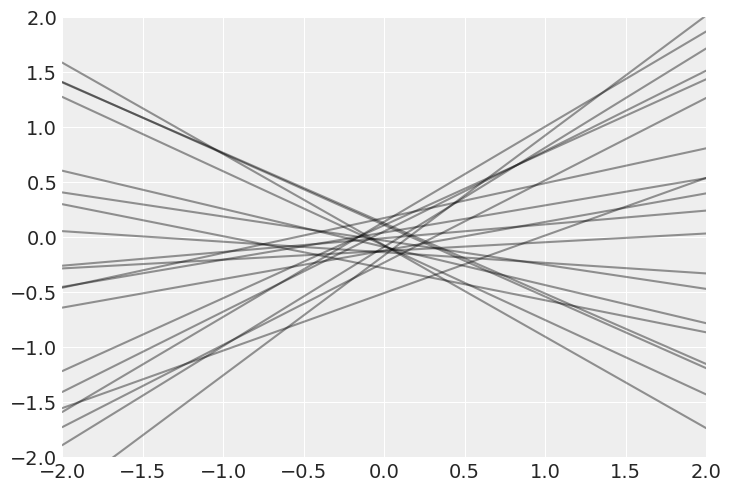

In [7]:
# Code 5.4

predictive = Predictive(m5_1.model, num_samples=1000, return_sites=["mu"])
prior_pred = predictive(random.PRNGKey(10), A=jnp.array([-2, 2]))
mu = prior_pred["mu"]
plt.subplot(xlim=(-2, 2), ylim=(-2, 2))
for i in range(20):
    plt.plot([-2, 2], mu[i], "k", alpha=0.4)



**Plausible regression lines implied by the priors in m5.1. These are weakly informative priors in that they allow some implusibly strong relationships but generally bound the lines to possible ranges of the variables.**

Posterior predictions

{'D': Array([[ 0.01291311,  1.0244976 ,  1.0216831 , ..., -0.43188217,
        -0.11671312, -1.0300978 ],
       [ 1.2175446 ,  2.3392973 ,  1.4535347 , ..., -1.4003607 ,
        -1.8314396 , -1.1385355 ],
       [ 2.7832944 ,  2.4582543 ,  2.333527  , ..., -3.2644312 ,
        -1.8059721 , -3.1461315 ],
       ...,
       [ 2.1809814 ,  4.434612  ,  3.1467478 , ..., -1.9179441 ,
        -3.8141713 , -3.5596461 ],
       [ 2.939217  ,  0.5206867 ,  1.2123939 , ..., -2.5008202 ,
         0.22669026, -1.9601085 ],
       [ 1.0575724 ,  1.2331138 ,  0.8083138 , ..., -0.57262903,
        -2.9795797 , -1.9380938 ]], dtype=float32), 'mu': Array([[ 1.0868802,  1.0033475,  0.9198148, ..., -1.1685035, -1.2520362,
        -1.335569 ],
       [ 1.8921056,  1.7620125,  1.6319197, ..., -1.6204054, -1.7504984,
        -1.8805915],
       [ 2.471807 ,  2.2991157,  2.1264248, ..., -2.1908553, -2.3635464,
        -2.5362377],
       ...,
       [ 2.212673 ,  2.0480516,  1.8834307, ..., -2.2320986, -2.3

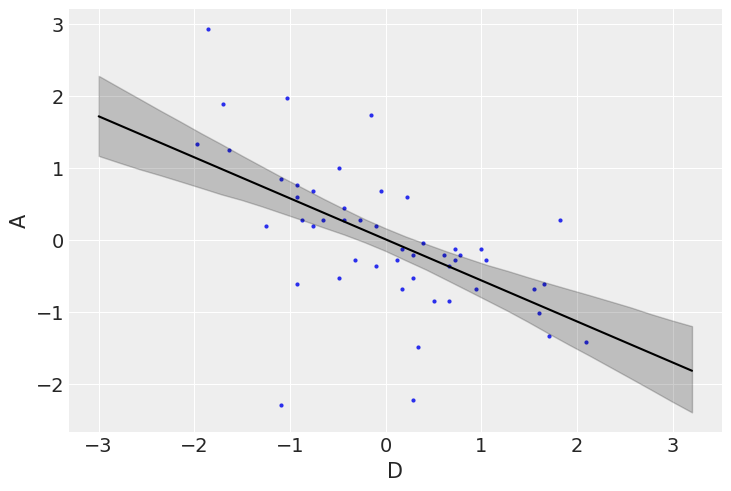

In [22]:
# Code 5.5

# compute percentile interval of mean
A_seq = jnp.linspace(start=-3, stop=3.2, num=30)
post = m5_1.sample_posterior(random.PRNGKey(1), p5_1, (1000,))
post_pred = Predictive(m5_1.model, post)(random.PRNGKey(2), A=A_seq)
print(post_pred)
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)

# plot it all
az.plot_pair(d[["D", "A"]].to_dict(orient="list"))
plt.plot(A_seq, mu_mean, "k")
plt.fill_between(A_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

Fit association of divorce rate with marriage rate

In [24]:
# Code 5.6

d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())


def model(M, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_2, optim.Adam(1), Trace_ELBO(), M=d.M.values, D=d.D.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_2 = svi_result.params

100%|███████████████| 1000/1000 [00:00<00:00, 2683.53it/s, init loss: 962.7465, avg. loss [951-1000]: 67.4809]


### Directed acyclic graph

*Graph* means it is nodes and connections. *Directed* means the connections have arrows that indicate directions of causal influence. And *acyclic* means that causes do not eventually flow back on themselves. A DAG is a way of describing qualitative causal relationships among variables. It isn’t as detailed as a full model description, but it contains information that a purely statistical model does not. Unlike a statistical model, a DAG, if it is correct, will tell you the consequences of intervening to change a variable

To infer the strength of these different arrows, we need more than one statistical model.

*Model m5.1*, the regression of **D** on **A**, tells us only that the total influence of age at marriage is
strongly negative with divorce rate. The “total” here means we have to account for every path
from A to D. There are two such paths in this graph: **A** → **D**, a direct path, and **A** → **M** → **D**,
an indirect path. In general, it is possible that a variable like A has no direct effect at all on an outcome like **D**. It could still be associated with D entirely through the indirect path. That type of relationship is known as _mediation_, and we’ll have another example later.

So which is it? Is there a direct effect of marriage rate, or rather is age at marriage just driving both, creating a spurious correlation between marriage rate and divorce rate? To find out, we need to slow down and consider carefully what each DAG implies. That’s what we’ll do next...

**Drawing a DAG**

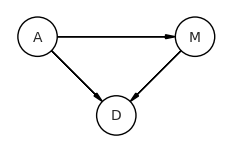

In [25]:
# Code 5.7

dag5_1 = CausalGraphicalModel(
    nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")]
)
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
with plt.rc_context({"figure.constrained_layout.use": False}):
    pgm.render()
plt.gca().invert_yaxis()

**Conditional independencies** come in two forms. First, they are statements of which variables
should be associated with one another (or not) in the data. Second, they are statements of
which variables become dis-associated when we condition on some other set of variables.

Visualize the implied conditional dependencies of the second DAG

In [26]:
# Code 5.8

DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('D', 'M', {'A'})


Visualize the implied conditional dependencies of the first DAG

In [31]:
# Code 5.9

DMA_dag1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M","D")])
all_independencies = DMA_dag1.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

So the only implication that differs between these DAGs is the last one: D ⊥⊥ M|A. To test this implication, we need a statistical model that conditions on A, so we can see whether that renders D independent of M. And that is what multiple regression helps with.

Multiple regression notation:

- Nominate the predictor variables you want in the linear model of the mean
- For each predictor, make a parameter that will measure its association with the outcome
- Multiply the parameter by the variable and add that term to the linear model

Approximating the posterior

In [32]:
# Code 5.10

def model(M, A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bM * M + bA * A)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model, m5_3, optim.Adam(1), Trace_ELBO(), M=d.M.values, A=d.A.values, D=d.D.values
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_3 = svi_result.params
post = m5_3.sample_posterior(random.PRNGKey(1), p5_3, (1000,))
print_summary(post, 0.89, False)

100%|██████████████| 1000/1000 [00:00<00:00, 2486.70it/s, init loss: 3201.7393, avg. loss [951-1000]: 60.7879]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.00      0.10     -0.01     -0.16      0.14   1049.96      1.00
        bA     -0.61      0.16     -0.61     -0.86     -0.35    984.99      1.00
        bM     -0.06      0.16     -0.06     -0.31      0.19    822.38      1.00
     mu[0]      0.37      0.14      0.36      0.15      0.58   1052.80      1.00
     mu[1]      0.32      0.20      0.32      0.02      0.66    917.91      1.00
     mu[2]      0.12      0.10      0.12     -0.04      0.27   1094.94      1.00
     mu[3]      0.76      0.21      0.75      0.43      1.09   1089.30      1.00
     mu[4]     -0.35      0.12     -0.35     -0.53     -0.16    869.88      1.00
     mu[5]      0.12      0.15      0.12     -0.10      0.36    968.97      1.00
     mu[6]     -0.71      0.17     -0.71     -0.98     -0.43    895.70      1.00
     mu[7]     -0.31      0.20     -0.32     -0.65      0.00    860.00      1.00
     mu[8]     -1.74      0

Visualize the posterior distributions for all three models

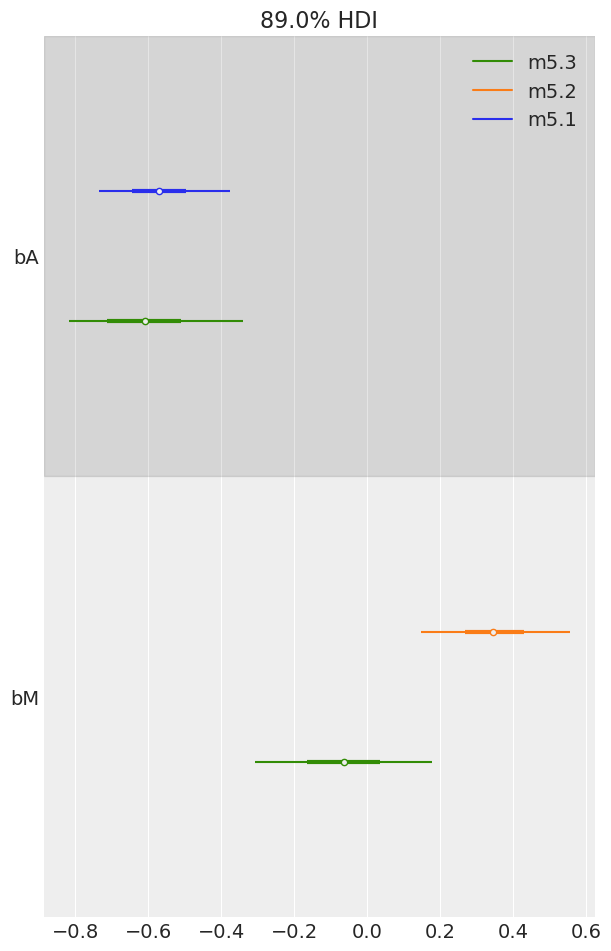

In [33]:
# Code 5.11

coeftab = {
    "m5.1": m5_1.sample_posterior(
        random.PRNGKey(1),
        p5_1,
        (
            1,
            1000,
        ),
    ),
    "m5.2": m5_2.sample_posterior(
        random.PRNGKey(2),
        p5_2,
        (
            1,
            1000,
        ),
    ),
    "m5.3": m5_3.sample_posterior(
        random.PRNGKey(3),
        p5_3,
        (
            1,
            1000,
        ),
    ),
}
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["bA", "bM"],
    hdi_prob=0.89,
)
plt.show()

### Once we know median age at marriage for a State, there is little or no additional predictive power in also knowing the rate of marriage in that State.

Simulate each of the three variables

In [34]:
# Code 5.12

N = 50  # number of simulated States
age = dist.Normal().sample(random.PRNGKey(0), sample_shape=(N,))  # sim A
mar = dist.Normal(age).sample(random.PRNGKey(1))  # sim A -> M
div = dist.Normal(age).sample(random.PRNGKey(2))  # sim A -> D

There is a huge literature detailing a variety of plotting techniques that all attempt to help one understand multiple linear regression. None of these techniques is suitable for all jobs, and most do not generalize beyond linear regression. So the approach I take here is to instead help you compute whatever you need from the model. I offer three examples of interpretive plots:

- (1) Predictor residual plots. These plots show the outcome against residual predictor values. They are useful for understanding the statistical model, but not much else.

- (2) Posterior prediction plots. These show model-based predictions against raw data, or otherwise display the error in prediction. They are tools for checking fit and assessing predictions. They are not causal tools.

- (3) Counterfactual plots. These show the implied predictions for imaginary experiments. These plots allow you to explore the causal implications of manipulating one or more variables.

**Predictor residual plots**

_"To compute predictor residuals for either, we just use the other predictor to model it."_

This code will approximate the posterior

In [35]:
# Code 5.13

def model(A, M=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bAM = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bAM * A)
    numpyro.sample("M", dist.Normal(mu, sigma), obs=M)


m5_4 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_4, optim.Adam(0.1), Trace_ELBO(), A=d.A.values, M=d.M.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_4 = svi_result.params

100%|██████████████| 1000/1000 [00:00<00:00, 2529.49it/s, init loss: 2288.6685, avg. loss [951-1000]: 53.6926]


In [36]:
# Code 5.14

post = m5_4.sample_posterior(random.PRNGKey(1), p5_4, (1000,))
post_pred = Predictive(m5_4.model, post)(random.PRNGKey(2), A=d.A.values)
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_resid = d.M.values - mu_mean

When a residual is positive, that means that the observed rate was in excess of what the model expects, given the median age at marriage in that State. When a residual is negative, that means the observed rate was below what the model expects. In simpler terms, States with positive residuals have high marriage rates for their median age of marriage, while States with negative residuals have low rates for their median age of marriage.

Regression models measure the remaining association of each predictor with the outcome, after already knowing the other predictors. In computing the predictor residual plots, you had to perform those calculations yourself. In the unified multivariate model, it all happens automatically. Nevertheless, it is useful to keep this fact in mind, because regressions can behave in surprising ways as a result.

**Posterior prediction plots**

Simulating predictions, averaging over the posterior

In [37]:
# Code 5.15

# call predictive without specifying new data
# so it uses original data
post = m5_3.sample_posterior(random.PRNGKey(1), p5_3, (int(1e4),))
post_pred = Predictive(m5_3.model, post)(random.PRNGKey(2), M=d.M.values, A=d.A.values)
mu = post_pred["mu"]

# summarize samples across cases
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)

# simulate observations
# again no new data, so uses original data
D_sim = post_pred["D"]
D_PI = jnp.percentile(D_sim, q=jnp.array([5.5, 94.5]), axis=0)

This code is similar to what you’ve seen before, but now using the original observed data. For multivariate models, there are many different ways to display these simulations. The simplest is to just plot predictions against observed. This code will do that, and then add a line to show perfect prediction and line segments for the confidence interval of each prediction:

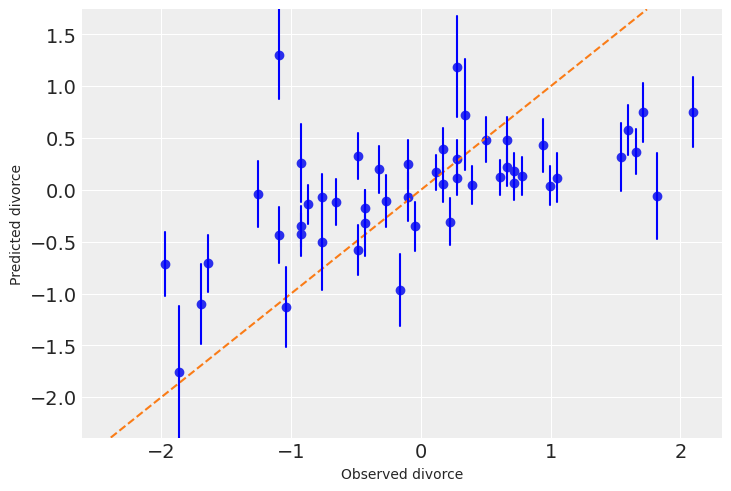

In [38]:
# Code 5.17

ax = plt.subplot(
    ylim=(float(mu_PI.min()), float(mu_PI.max())),
    xlabel="Observed divorce",
    ylabel="Predicted divorce",
)
plt.plot(d.D, mu_mean, "o")
x = jnp.linspace(mu_PI.min(), mu_PI.max(), 101)
plt.plot(x, x, "--")
for i in range(d.shape[0]):
    plt.plot([d.D[i]] * 2, mu_PI[:, i], "b")
fig = plt.gcf()

We see that the model under-predicts for States with very high divorce rates while it overpredicts for States with very low divorce rate.

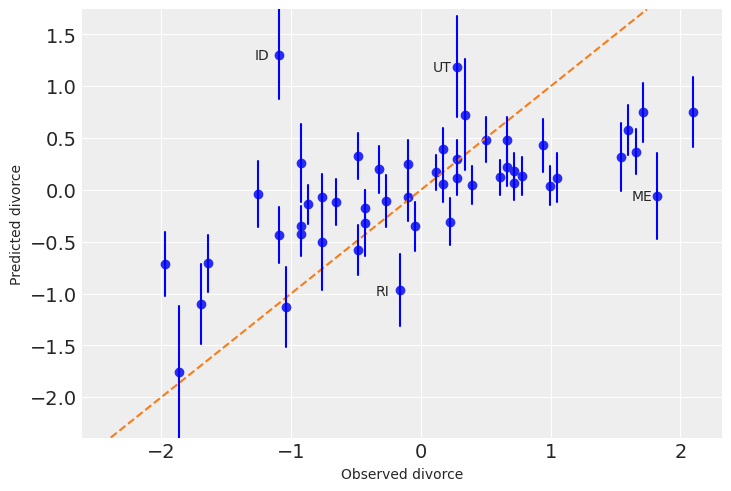

In [39]:
# Code 5.17

for i in range(d.shape[0]):
    if d.Loc[i] in ["ID", "UT", "RI", "ME"]:
        ax.annotate(
            d.Loc[i], (d.D[i], mu_mean[i]), xytext=(-25, -5), textcoords="offset pixels"
        )
fig

**Counterfactual plots**

The simplest use of a counterfactual plot is to see how the predictions change as you
change only one predictor at a time.

How do we genrate plots of model predictions that take the causal structure into account. The basic recipe is (1) pick a variable to manipulate, the intervention variable, (2) define the range of values to set the intervention variable to, (3) for each value of the intervetion variable, and for each sample in the posterior, use the causal model to simulate the values of other variables, including the outcome.

To simulate from this, we need more than the DAG. We also need a set of functions that tell
us how each variable is generated. For simplicity, we’ll use Gaussian distributions for each
variable, just like in model m5.3. But model m5.3 ignored the assumption that A influences
M. We didn’t need that to estimate A → D. But we do need it to predict the consequences
of manipulating A, because some of the effect of A acts through M.
To estimate the influence of A on M, all we need is to regress A on M, there are no
other variables in the DAG creating an association between A and M. We can just add this
regression to the quap() model, running two regressions at the same time:

In [41]:
# Code 5.19

WaffleDivorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())


def model(A, M=None, D=None):
    # A -> M
    aM = numpyro.sample("aM", dist.Normal(0, 0.2))
    bAM = numpyro.sample("bAM", dist.Normal(0, 0.5))
    sigma_M = numpyro.sample("sigma_M", dist.Exponential(1))
    mu_M = aM + bAM * A
    M = numpyro.sample("M", dist.Normal(mu_M, sigma_M), obs=M)
    # A -> D <- M
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M + bA * A
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_3_A = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_3_A,
    optim.Adam(0.1),
    Trace_ELBO(),
    A=d.A.values,
    M=d.M.values,
    D=d.D.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_3_A = svi_result.params

100%|████████████| 1000/1000 [00:00<00:00, 1122.16it/s, init loss: 10480.9570, avg. loss [951-1000]: 114.4805]


You’ll see that M and A are strongly negatively asso-
ciated. If we interpret this causally, it indicates that manipulating A reduces M

In [44]:
post = m5_3_A.sample_posterior(random.PRNGKey(1), p5_3_A, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.00      0.10     -0.01     -0.16      0.15    853.86      1.00
        aM     -0.00      0.09      0.00     -0.14      0.14    983.38      1.00
        bA     -0.60      0.16     -0.61     -0.84     -0.33   1002.25      1.00
       bAM     -0.69      0.10     -0.69     -0.84     -0.54   1023.78      1.00
        bM     -0.05      0.16     -0.05     -0.31      0.20   1014.77      1.00
     sigma      0.80      0.08      0.80      0.68      0.93   1012.07      1.00
   sigma_M      0.69      0.07      0.69      0.57      0.79   1027.73      1.00



The goal is to simulate what would happen, if we manipulate A. So next we define a range of values for A.

This defines a list of 30 imaginary interventions, ranging from 2 standard deviations below
and 2 above the mean. Now we can use sim(), which you met in the previous chapter, to
simulate observations from model m5.3_A. But this time we’ll tell it to simulate both M and
D, in that order. Why in that order? Because we have to simulate the influence of A on M
before we simulate the joint influence of A and M on D.

In [43]:
# Code 5.20

A_seq

Array([-2.        , -1.8620689 , -1.724138  , -1.5862069 , -1.4482758 ,
       -1.3103449 , -1.1724138 , -1.0344827 , -0.89655167, -0.75862074,
       -0.62068963, -0.48275858, -0.34482765, -0.20689654, -0.06896549,
        0.06896549,  0.20689654,  0.3448276 ,  0.48275858,  0.62068963,
        0.75862074,  0.89655167,  1.0344827 ,  1.1724138 ,  1.3103447 ,
        1.4482758 ,  1.5862069 ,  1.724138  ,  1.8620689 ,  2.        ],      dtype=float32)

In [46]:
# Code 5.21

# prep data
sim_dat = dict(A=A_seq)

# simulate M and then D, using A_seq
post = m5_3_A.sample_posterior(random.PRNGKey(1), p5_3_A, (1000,))
s = Predictive(m5_3_A.model, post)(random.PRNGKey(2), **sim_dat)

Now to plot the predictions

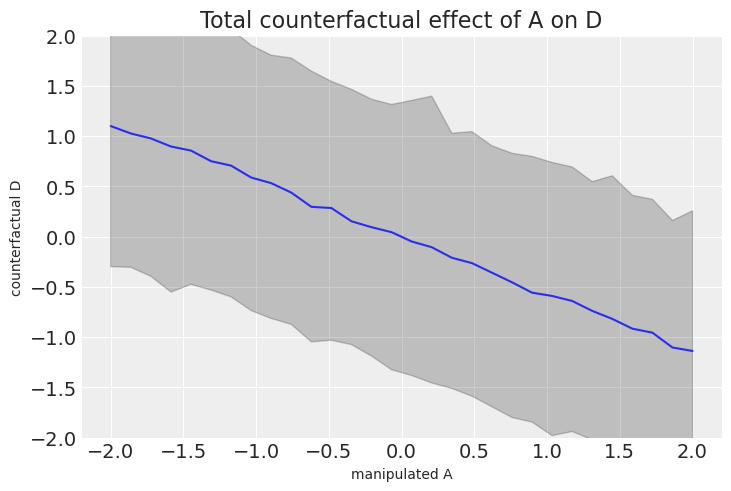

In [47]:
# Code 5.22

plt.plot(sim_dat["A"], jnp.mean(s["D"], 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated A", ylabel="counterfactual D")
plt.fill_between(
    sim_dat["A"],
    *jnp.percentile(s["D"], q=jnp.array([5.5, 94.5]), axis=0),
    color="k",
    alpha=0.2
)
plt.title("Total counterfactual effect of A on D")
plt.show()

**This predicted trend in D include both
paths: A → D and A → M → D. We found previously that M → D is very small, so the
second path doesn’t contribute much to the trend. But if M were to strongly influence D, the
code above would include the effect.**

The counterfactual simulation also generated values for M. The object s from the code above includes these simulated M values. Try to reproduce the figure yourself, by modifying the plotting code.

The trick with simulating counterfactuals is to realize that when we manipulate some
variable X, we break the causal influence of other variables on X. Suppose for example that we now simulate
the effect of manipulating M. This implies the arrow A → M is deleted, because if we control the values of M, then A no longer influences it. It’s like a perfectly controlled experiment. Now we can modify the code above to
simulate the counterfactual result of manipulating M. We’ll simulate a counterfactual for an
average state, with A = 0, and see what changing M does.

In [53]:
# Code 5.23

# new data frame, standardized to mean 26.1 and stddev 1.24
sim2_dat = dict(A=(jnp.array([20, 30]) - 26.1) / 1.24)
s2 = Predictive(m5_3_A.model, post, return_sites=["M", "D"])(
    random.PRNGKey(2), **sim2_dat
)
jnp.mean(s2["D"][:, 1] - s2["D"][:, 0])

Array(-4.632526, dtype=float32)

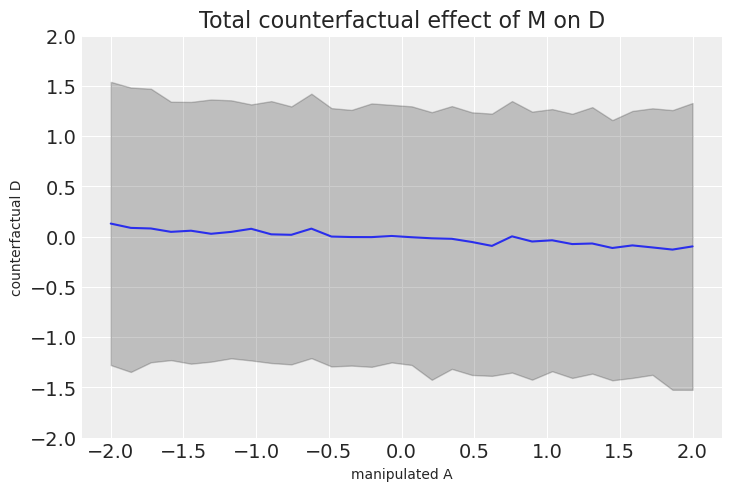

In [61]:
# Code 5.24

sim_dat = dict(M=jnp.linspace(-2, 2, num=30), A=0)
s = Predictive(m5_3_A.model, post)(random.PRNGKey(2), **sim_dat)["D"]

plt.plot(sim_dat["M"], jnp.mean(s, 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated A", ylabel="counterfactual D")
plt.fill_between(
    sim_dat["M"],
    *jnp.percentile(s, q=jnp.array([5.5, 94.5]), axis=0),
    color="k",
    alpha=0.2
)
plt.title("Total counterfactual effect of M on D")
plt.show()

**The counterfactual effect of manipulating marriage rate M on divorce rate D. Since M → D was estimated to be very small, there is almost no trend here. By manipulating M, we break the influence of A on M, and this removes the association between M and D.**

In more complex models with many potential paths, the same strategy will compute
counterfactuals for an exposure of interest. But as you’ll see in later examples, often it is
simply not possible to estimate a plausible, un-confounded causal effect of some exposure
X on some outcome Y. But even in those cases, there are still important counterfactuals to
consider. So we’ll return to this theme in future chapters.


## 5.2 Masked relationship

In [3]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  
0         67.98  1.95           55.16  
1         63.82  2.09             NaN  
2         69.04  2.51             NaN  
3         71.91  1.62             NaN  
4         53.22  2.19             NaN

A popular hypothesis has it that primates with larger brains produce more energetic
milk, so that brains can grow quickly.

The variables we’ll consider for now are:
- kcal.per.g : Kilocalories of energy per gram of milk

- mass : Average female body mass, in kilograms.

- neocortex.perc : The percent of total brain mass that is neocortex mass.
    
The question here is to what extent energy content of milk, measured here by kilocalories, is
related to the percent of the brain mass that is neocortex. Neocortex is the gray, outer part
of the brain that is particularly elaborated in mammals and especially primates. We’ll end
up needing female body mass as well, to see the masking that hides the relationships among
the variables. Let’s standardize these three variables

In [4]:
d['K'] = d['kcal.per.g'].pipe(lambda x: (x - x.mean()) / x.std())

In [5]:
d["N"] = d["neocortex.perc"].pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.mass.map(math.log).pipe(lambda x: (x - x.mean()) / x.std())

We will first a simply bivariate regression of K and N.

$K_i$ ∼ Normal($μ_i$, σ)

$μ_i$ = α + $β_N$N

In [6]:
# Code 5.30
def model(N, K):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bN = numpyro.sample("bN", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bN * N
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


with numpyro.validation_enabled():
    try:
        m5_5_draft = AutoLaplaceApproximation(model)
        svi = SVI(
            model, m5_5_draft, optim.Adam(1), Trace_ELBO(), N=d.N.values, K=d.K.values
        )
        svi_result = svi.run(random.PRNGKey(0), 1000)
        p5_5_draft = svi_result.params
    except ValueError as e:
        print(str(e))

Normal distribution got invalid loc parameter.


In [7]:
# Code 5.31
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

### Complete case analysis

In [8]:
# Code 5.32
dcc = d.iloc[d[['K','N','M']].dropna(how='any',axis=0).index]

In [9]:
dcc

clade                  species  kcal.per.g  perc.fat  \
0      Strepsirrhine           Eulemur fulvus        0.49     16.60   
5   New World Monkey       Alouatta seniculus        0.47     21.22   
6   New World Monkey               A palliata        0.56     29.66   
7   New World Monkey             Cebus apella        0.89     53.41   
9   New World Monkey               S sciureus        0.92     50.58   
10  New World Monkey         Cebuella pygmaea        0.80     41.35   
11  New World Monkey        Callimico goeldii        0.46      3.93   
12  New World Monkey       Callithrix jacchus        0.71     38.38   
15  Old World Monkey      Miopithecus talpoin        0.68     40.15   
17  Old World Monkey                M mulatta        0.97     55.51   
19  Old World Monkey                Papio spp        0.84     54.31   
21               Ape            Hylobates lar        0.62     34.51   
23               Ape           Pongo pygmaeus        0.54     37.78   
24               Ape  Gorilla gorilla gorilla        0.49     27.18   
26               Ape             Pan paniscus        0.48     21.18   
27               Ape            P troglodytes        0.55     36.84   
28               Ape             Homo sapiens        0.71     50.49   

    perc.protein  perc.lactose   mass  neocortex.perc         K         N  \
0          15.42         67.98   1.95           55.16 -0.940041 -2.080196   
5          23.58         55.20   5.25           64.54 -1.063955 -0.508641   
6          23.46         46.88   5.37           64.54 -0.506340 -0.508641   
7          15.80         30.79   2.51           67.64  1.538249  0.010742   
9          22.33         27.09   0.68           68.85  1.724120  0.213470   
10         20.85         37.80   0.12           58.85  0.980633 -1.461962   
11         25.30         70.77   0.47           61.69 -1.125913 -0.986139   
12         20.09         41.53   0.32           60.32  0.423018 -1.215673   
15         18.08         41.77   1.55           69.97  0.237147  0.401118   
17         13.17         31.32   3.24           70.41  2.033906  0.474837   
19         10.97         34.72  12.30           73.40  1.228462  0.975791   
21         12.57         52.92   5.37           67.53 -0.134597 -0.007687   
23          7.37         54.85  35.48           71.26 -0.630255  0.617249   
24         16.29         56.53  79.43           72.60 -0.940041  0.841756   
26         11.68         67.14  40.74           70.24 -1.001998  0.446355   
27          9.54         53.62  33.11           76.30 -0.568297  1.461666   
28          9.84         39.67  54.95           75.49  0.423018  1.325956   

           M  
0  -0.455836  
5   0.127441  
6   0.140751  
7  -0.307158  
9  -1.076270  
10 -2.097830  
11 -1.293797  
12 -1.520189  
15 -0.591039  
17 -0.156810  
19  0.628840  
21  0.140751  
23  1.252735  
24  1.727359  
26  1.334150  
27  1.212020  
28  1.510366

Writing out the first model **m5_5_draft** with some standardized (but likely uninformative priors).

In [10]:
# Code 5.33
def model(N, K=None):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bN = numpyro.sample("bN", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bN * N)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m5_5_draft = AutoLaplaceApproximation(model)
svi = SVI(
    model, m5_5_draft, optim.Adam(0.1), Trace_ELBO(), N=dcc.N.values, K=dcc.K.values
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_5_draft = svi_result.params

100%|███████████████| 1000/1000 [00:00<00:00, 1641.77it/s, init loss: 411.1621, avg. loss [951-1000]: 27.4243]


**Understanding priors**

Plot 50 prior regression lines for:

- a ~ dnorm(0, 1)

- bN ~ dnorm(0, 1)

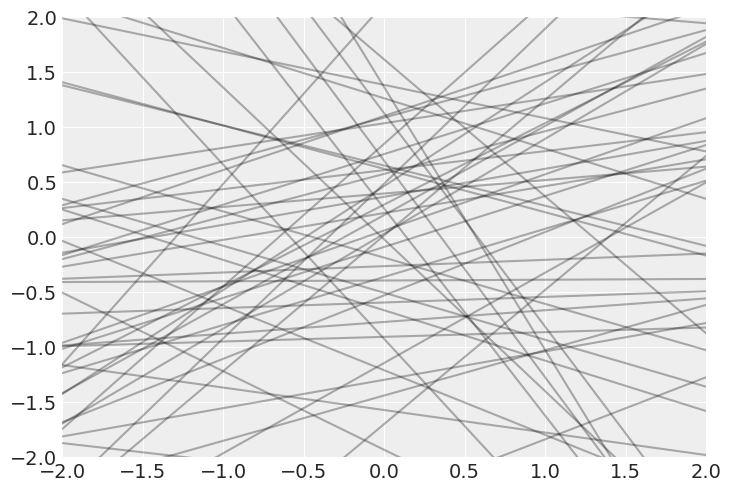

In [11]:
# Code 5.34
xseq = jnp.array([-2, 2])
prior_pred = Predictive(model, num_samples=1000)(random.PRNGKey(1), N=xseq)
mu = prior_pred["mu"]
plt.subplot(xlim=xseq, ylim=xseq)
for i in range(50):
    plt.plot(xseq, mu[i], "k", alpha=0.3)

We can do better by both tightening the α prior so that it sticks closer
to zero. With two standardized variables, when predictor is zero, the expected value of the
outcome should also be zero. And the slope $β_N$ needs to be a bit tighter as well, so that it
doesn’t regularly produce impossibly strong relationships.

In [12]:
# Code 5.35
def model(N, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bN = numpyro.sample("bN", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bN * N)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m5_5 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_5, optim.Adam(1), Trace_ELBO(), N=dcc.N.values, K=dcc.K.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_5 = svi_result.params

100%|███████████████| 1000/1000 [00:00<00:00, 1435.94it/s, init loss: 414.1050, avg. loss [951-1000]: 25.1957]


Plot 50 prior regression lines for:

- a ~ dnorm(0, 0.2)

- bN ~ dnorm(0, 0.5)

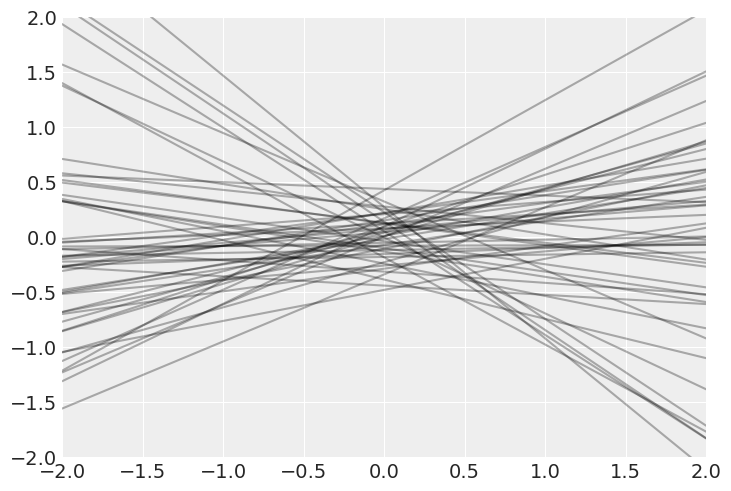

In [13]:
xseq = jnp.array([-2, 2])
prior_pred = Predictive(model, num_samples=1000)(random.PRNGKey(1), N=xseq)
mu = prior_pred["mu"]
plt.subplot(xlim=xseq, ylim=xseq)
for i in range(50):
    plt.plot(xseq, mu[i], "k", alpha=0.3)

In [14]:
# Code 5.36
post = m5_5.sample_posterior(random.PRNGKey(1), p5_5, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.05      0.16      0.05     -0.21      0.29    931.50      1.00
        bN      0.13      0.23      0.13     -0.21      0.53   1111.88      1.00
     mu[0]     -0.22      0.51     -0.22     -0.99      0.60    911.65      1.00
     mu[1]     -0.02      0.20     -0.01     -0.36      0.27    906.66      1.00
     mu[2]     -0.02      0.20     -0.01     -0.36      0.27    906.66      1.00
     mu[3]      0.05      0.16      0.05     -0.21      0.29    931.28      1.00
     mu[4]      0.08      0.17      0.08     -0.18      0.36    940.50      1.00
     mu[5]     -0.14      0.38     -0.13     -0.74      0.45    889.84      1.00
     mu[6]     -0.08      0.28     -0.07     -0.52      0.36    874.50      1.00
     mu[7]     -0.11      0.33     -0.10     -0.65      0.37    884.63      1.00
     mu[8]      0.10      0.18      0.10     -0.18      0.41    964.72      1.00
     mu[9]      0.11      0

From this summary, you can possibly see that this is neither a strong nor very precise asso-
ciation. The standard deviation is almost twice the posterior mean. But as always, it’s much
easier to see this if we draw a picture. Tables of numbers are golem speak, and we are not
golems.

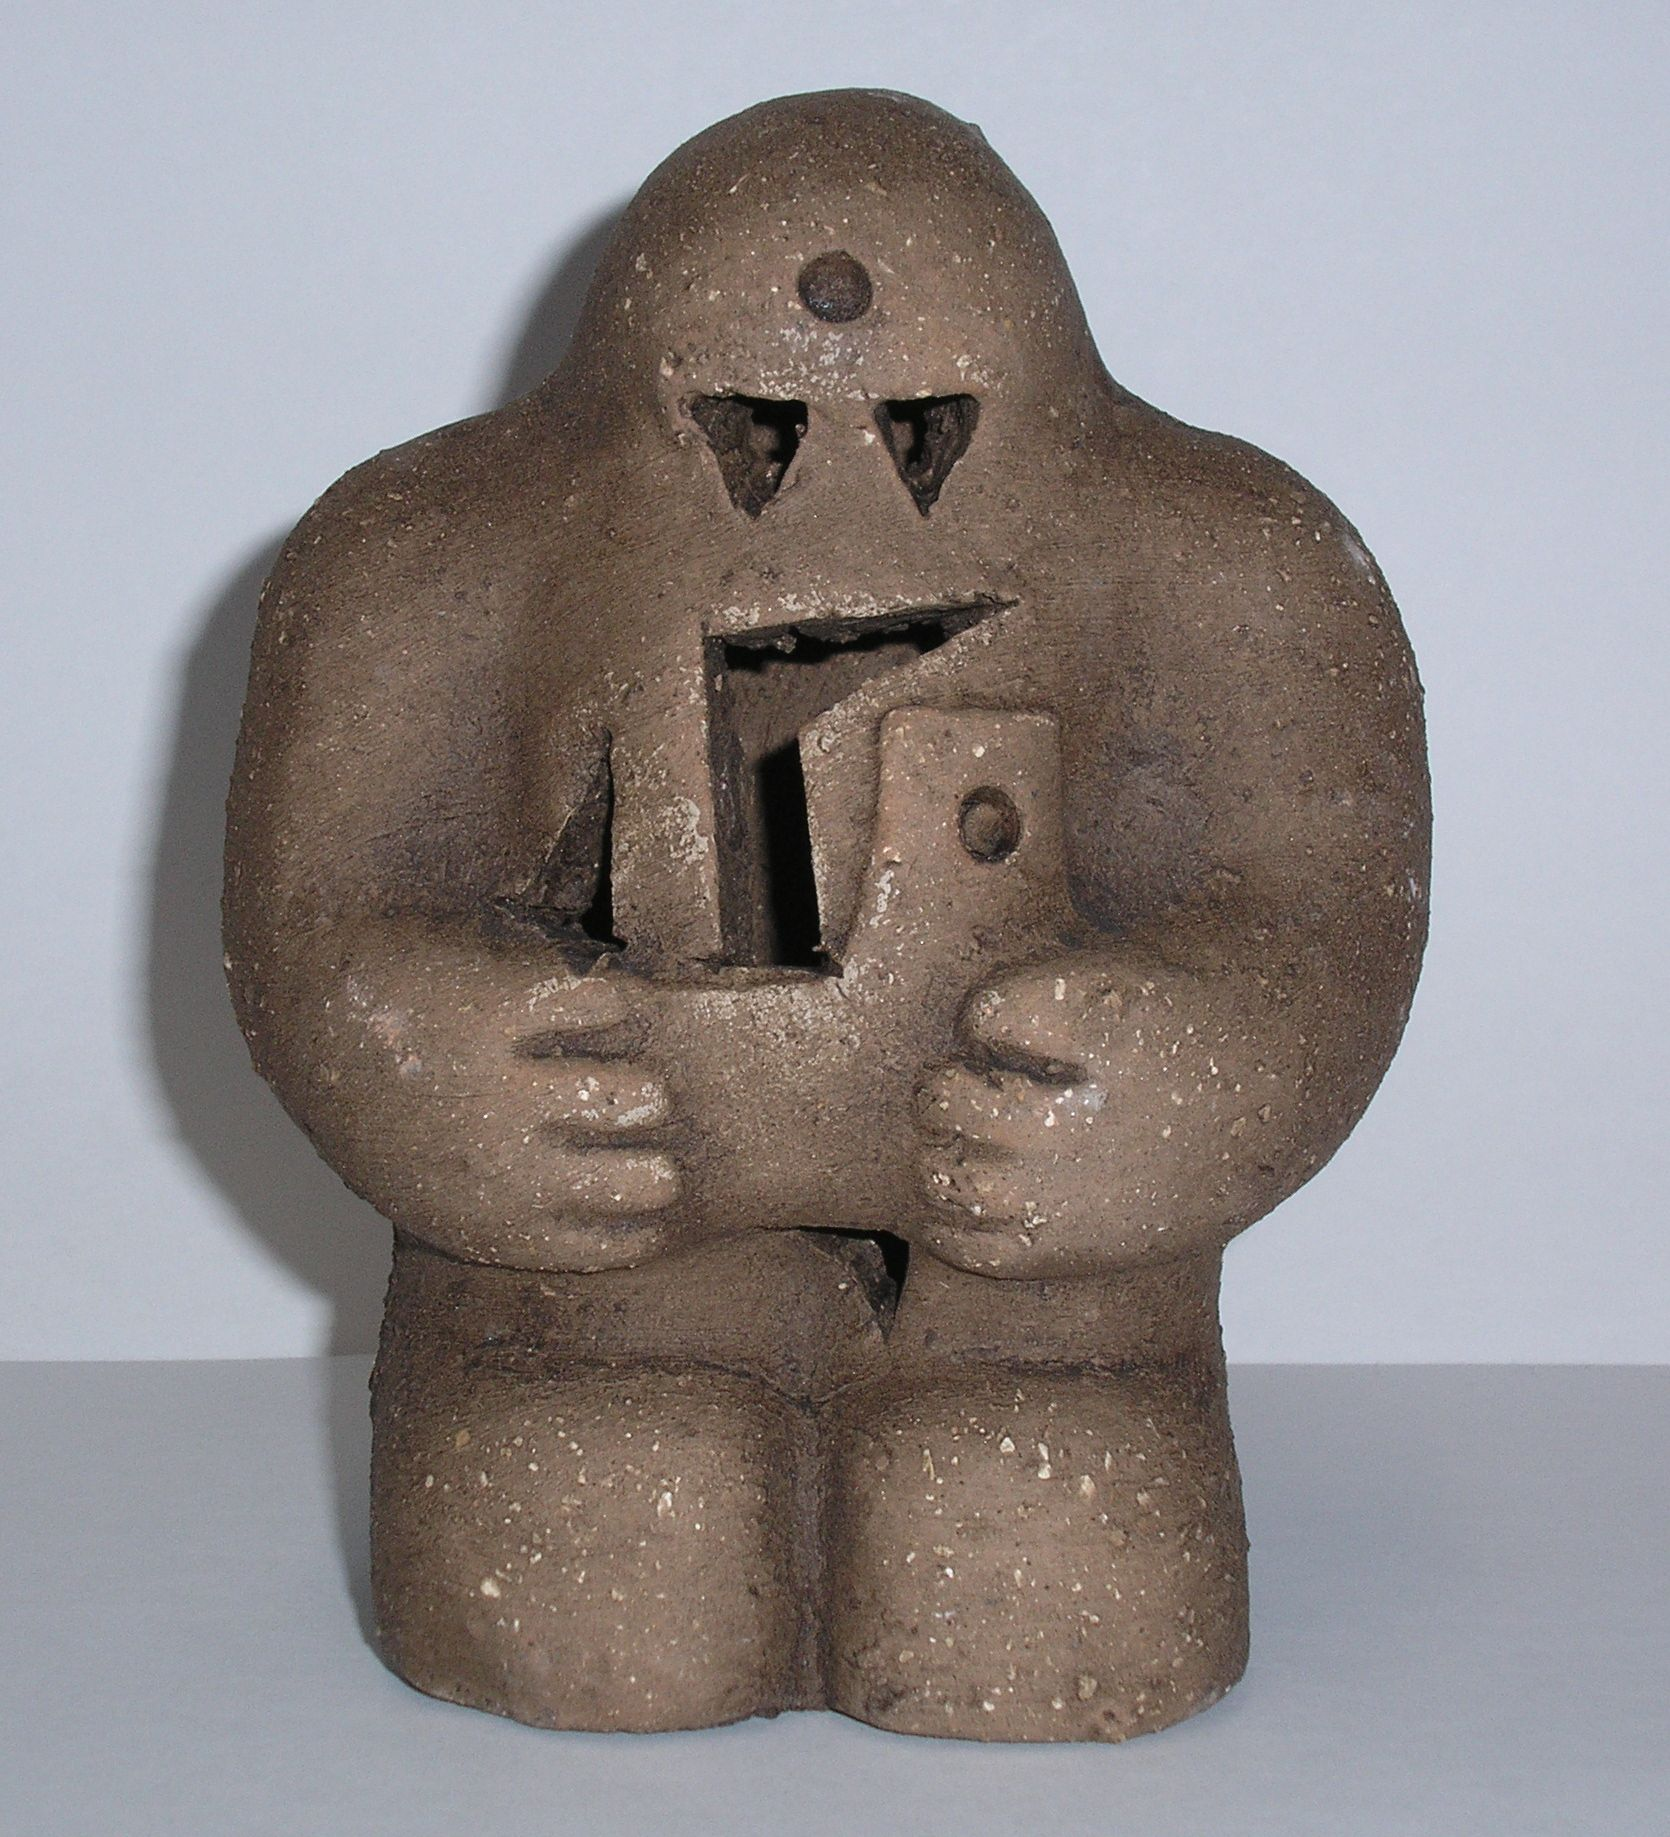

_:(_

We can plot the predicted mean and 89% compatibility interval for the mean to see
this more easily:

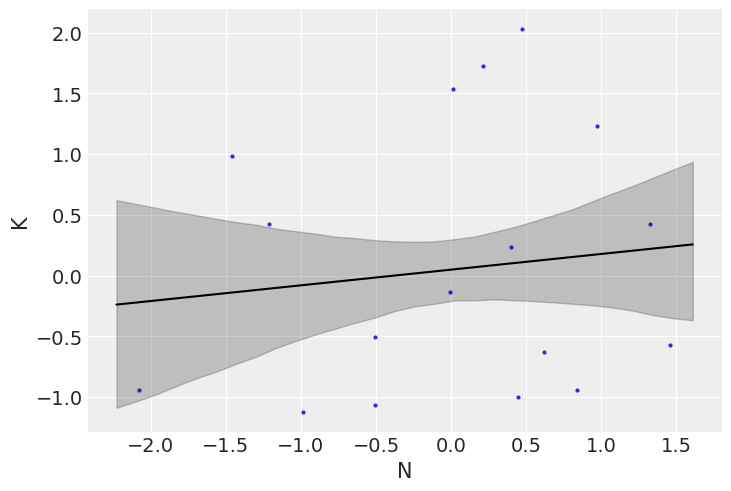

In [15]:
xseq = jnp.linspace(start=dcc.N.min() - 0.15, stop=dcc.N.max() + 0.15, num=30)
post = m5_5.sample_posterior(random.PRNGKey(1), p5_5, (1000,))
post_pred = Predictive(m5_5.model, post)(random.PRNGKey(2), N=xseq)
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)
az.plot_pair(dcc[["N", "K"]].to_dict(orient="list"))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()


Weakly positive, but highly imprecise...

### Adult female body mass as predictor

Log-scaling mass to translate mass into a magnitude of (mother's body mass) milk energy in a linear fashion.

In [16]:
# Code 5.38
def model(M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bM * M)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m5_6 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_6, optim.Adam(1), Trace_ELBO(), M=dcc.M.values, K=dcc.K.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_6 = svi_result.params
post = m5_6.sample_posterior(random.PRNGKey(1), p5_6, (1000,))
print_summary(post, 0.89, False)

100%|███████████████| 1000/1000 [00:00<00:00, 2239.34it/s, init loss: 756.0300, avg. loss [951-1000]: 24.4211]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.06      0.16      0.06     -0.20      0.29    931.50      1.00
        bM     -0.28      0.20     -0.28     -0.61      0.03   1088.44      1.00
     mu[0]      0.18      0.18      0.19     -0.11      0.47    944.38      1.00
     mu[1]      0.02      0.16      0.02     -0.24      0.26    932.90      1.00
     mu[2]      0.02      0.16      0.02     -0.24      0.26    933.51      1.00
     mu[3]      0.14      0.17      0.15     -0.11      0.42    958.01      1.00
     mu[4]      0.36      0.27      0.36     -0.07      0.78    872.95      1.00
     mu[5]      0.65      0.45      0.65     -0.03      1.39    898.90      1.00
     mu[6]      0.42      0.31      0.43     -0.07      0.89    878.58      1.00
     mu[7]      0.49      0.35      0.50     -0.09      1.00    885.51      1.00
     mu[8]      0.22      0.20      0.23     -0.12      0.51    906.05      1.00
     mu[9]      0.10      0

Stronger and oppositely (negative) relationship between K and log(mass).

Again plot the 89% CI for the mean.

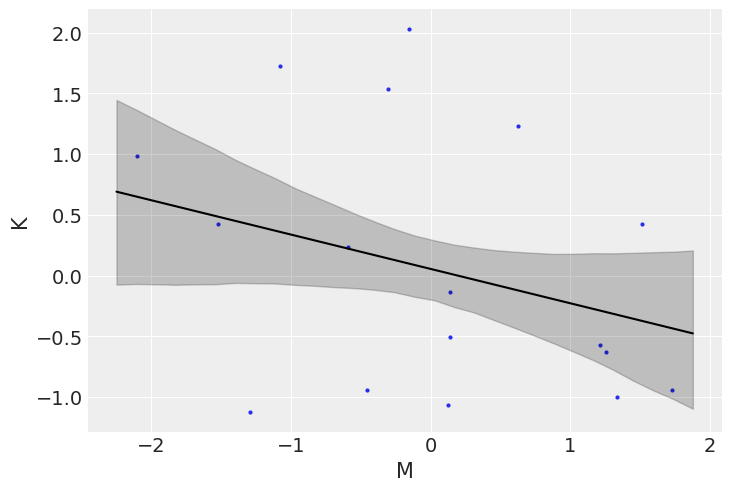

In [17]:
xseq = jnp.linspace(start=dcc.M.min() - 0.15, stop=dcc.M.max() + 0.15, num=30)

post = m5_6.sample_posterior(random.PRNGKey(1), p5_6, (1000,))
post_pred = Predictive(m5_6.model, post)(random.PRNGKey(2), M=xseq)

mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)

az.plot_pair(dcc[["M", "K"]].to_dict(orient="list"))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()


### Multivariate model

$K_i$ ∼ Normal($μ_i$, σ)

$μ_i$ = α + $β_N$ $N_i$ + $β_M$ $M_i$

α ∼ Normal(0, 0.2)

$β_n$ ∼ Normal(0, 0.5)

$β_m$ ∼ Normal(0, 0.5)

σ ∼ Exponential(1)

In [18]:
# Code 5.39
def model(N, M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bN = numpyro.sample("bN", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bN * N + bM * M)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)

m5_7 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_7,
    optim.Adam(1),
    Trace_ELBO(),
    N=dcc.N.values,
    M=dcc.M.values,
    K=dcc.K.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_7 = svi_result.params
post = m5_7.sample_posterior(random.PRNGKey(1), p5_7, (1000,))
print_summary(post, 0.89, False)

100%|███████████████| 1000/1000 [00:00<00:00, 1532.46it/s, init loss: 136.3944, avg. loss [951-1000]: 22.0707]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.06      0.13      0.06     -0.15      0.26   1049.96      1.00
        bM     -0.69      0.23     -0.69     -1.05     -0.32    887.31      1.00
        bN      0.67      0.26      0.67      0.24      1.09    810.77      1.00
     mu[0]     -1.01      0.49     -1.02     -1.88     -0.31    903.36      1.00
     mu[1]     -0.36      0.20     -0.36     -0.67     -0.04    892.91      1.00
     mu[2]     -0.37      0.20     -0.37     -0.68     -0.05    890.73      1.00
     mu[3]      0.28      0.15      0.28      0.03      0.52   1132.15      1.00
     mu[4]      0.95      0.32      0.96      0.50      1.50    979.70      1.00
     mu[5]      0.54      0.38      0.53     -0.10      1.09   1065.64      1.00
     mu[6]      0.30      0.26      0.30     -0.11      0.69   1075.27      1.00
     mu[7]      0.30      0.30      0.30     -0.15      0.77   1062.82      1.00
     mu[8]      0.74      0

By incorporating both predictor variables in the regression, the posterior association of both
with the outcome has increased. Visually comparing this posterior to those of the previous
two models helps:

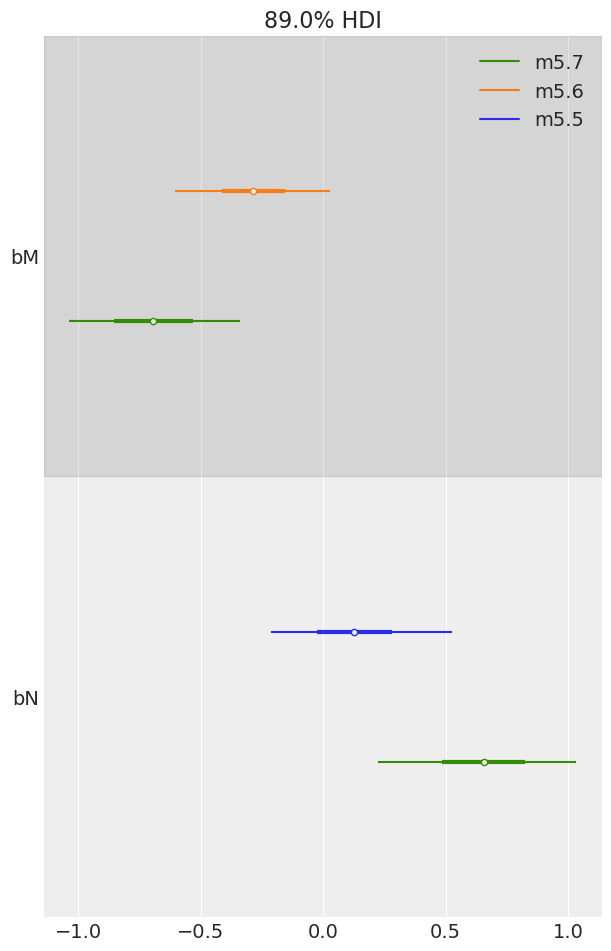

In [19]:
# Code 5.40
coeftab = {
    "m5.5": m5_5.sample_posterior(
        random.PRNGKey(1),
        p5_5,
        (
            1,
            1000,
        ),
    ),
    "m5.6": m5_6.sample_posterior(
        random.PRNGKey(2),
        p5_6,
        (
            1,
            1000,
        ),
    ),
    "m5.7": m5_7.sample_posterior(
        random.PRNGKey(3),
        p5_7,
        (
            1,
            1000,
        ),
    ),
}
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["bM", "bN"],
    hdi_prob=0.89,
)
plt.show()

What happened? Why did adding N and M to the same model lead to larger estimated effects of both? This is a context in whcih there are two variables correlated with the outcome, but one is positively ocrrelated with it and the other is negatively correlated wth it. In addition, both of the explanatory variables are positively correlated with one another. As a result, they tend to cancel one another out.

Bigger species, like apes, have milk with less energy. But species with more neocortex tend
to have richer milk. The fact that these two variables, body size and neocortex, are correlated
across species makes it hard to see these relationships, unless we account for both.
Some DAGs will help. There are at least three graphs consistent with the pattern in these
data.

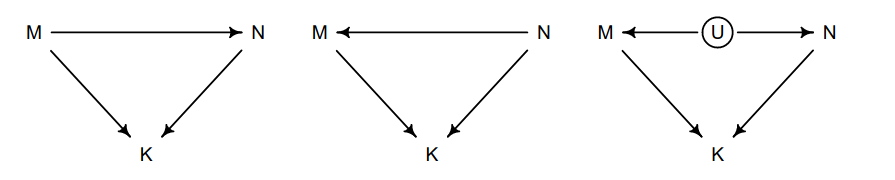

**Finally, on the right, there could be an unobserved variable U that influences both M and N, produc-
ing a correlation between them.**

### Counterfactual plots

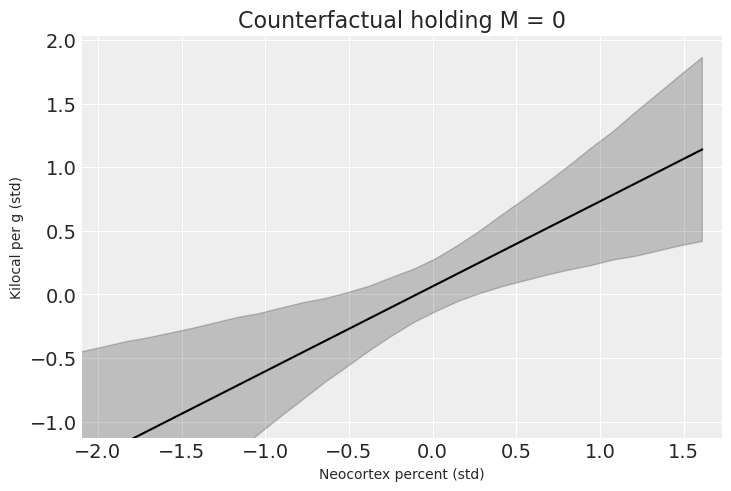

In [20]:
# Code 5.41
xseq = jnp.linspace(start=dcc.N.min() - 0.15, stop=dcc.N.max() + 0.15, num=30)
post = m5_7.sample_posterior(random.PRNGKey(1), p5_7, (1000,))
# Highlighted code here: M=0
post_pred = Predictive(m5_7.model, post)(random.PRNGKey(2), M=0, N=xseq)
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)
plt.subplot(xlim=(dcc.M.min(), dcc.M.max()), ylim=(dcc.K.min(), dcc.K.max()))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.xlabel('Neocortex percent (std)')
plt.ylabel('Kilocal per g (std)')
plt.title('Counterfactual holding M = 0')
plt.show()

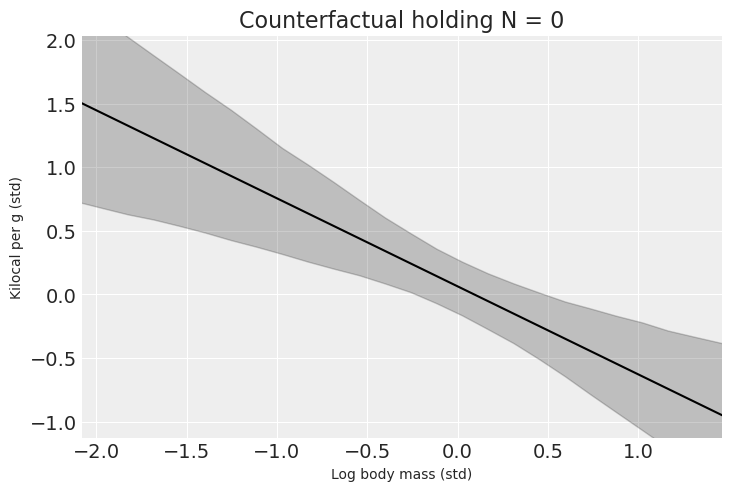

In [21]:
# Code 5.41 adapted for N=0
xseq = jnp.linspace(start=dcc.M.min() - 0.15, stop=dcc.M.max() + 0.15, num=30)
post = m5_7.sample_posterior(random.PRNGKey(1), p5_7, (1000,))
# Highlighted code here: M=0
post_pred = Predictive(m5_7.model, post)(random.PRNGKey(2), N=0, M=xseq)
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)
plt.subplot(xlim=(dcc.N.min(), dcc.N.max()), ylim=(dcc.K.min(), dcc.K.max()))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.xlabel('Log body mass (std)')
plt.ylabel('Kilocal per g (std)')
plt.title('Counterfactual holding N = 0')
plt.show()

### Simulating a masking relationship

It is unclear which of the three DAGs is correct. From the data we can not tell it, because all three graphs imply the same set of **conditional independencies**. Here, there are no conditional independencies because each DAG above implies that all pairs of variables are associated with each other, regardless of what we condition on.

A set of DAGs with the same conditional independencies is known as a **Markov equivalance** set.

Although the data alone can not tell you which causal model is correct, relying on your scientific knowledge of the variables will eliminate many silly but Markov equivalent DAGs.

**Masking a realtionship**. It may help to simulate data in which two meaningful predictors act to mask one another. Simulating data consistent with the first DAG:

In [22]:
# Code 5.42

# M -> K <- N
# M -> N
n = 100
M = dist.Normal().sample(random.PRNGKey(0), (n,))
N = dist.Normal(M).sample(random.PRNGKey(1))
K = dist.Normal(N - M).sample(random.PRNGKey(2))
d_sim = pd.DataFrame({"K": K, "N": N, "M": M})

Masking can be observed by replacing _dcc_ with *d_sim* in models m5_5, m5_6 and *m_5_7*. 

Inspect the summaries to see the same masking pattern where the slopes become more extreme in *m5_7*.

In [23]:
def model(N, M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bN = numpyro.sample("bN", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bN * N + bM * M)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m_left_DAG = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m_left_DAG,
    optim.Adam(1),
    Trace_ELBO(),
    N=d_sim.N.values,
    M=d_sim.M.values,
    K=d_sim.K.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p_left_DAG = svi_result.params
post = m_left_DAG.sample_posterior(random.PRNGKey(1), p_left_DAG, (1000,))
print_summary(post, 0.89, False)

100%|█████████████| 1000/1000 [00:00<00:00, 1781.38it/s, init loss: 1521.8649, avg. loss [951-1000]: 137.7879]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.00      0.08     -0.01     -0.13      0.12   1049.96      1.00
        bM     -1.03      0.13     -1.03     -1.23     -0.82    900.83      1.00
        bN      1.02      0.09      1.02      0.87      1.17    814.26      1.00
     mu[0]     -1.85      0.29     -1.85     -2.29     -1.38   1004.72      1.00
     mu[1]     -0.21      0.13     -0.21     -0.39      0.01    891.94      1.00
     mu[2]     -1.73      0.19     -1.73     -2.00     -1.42    859.01      1.00
     mu[3]     -1.37      0.15     -1.37     -1.58     -1.12    893.45      1.00
     mu[4]      0.77      0.14      0.77      0.57      1.02   1114.07      1.00
     mu[5]      0.62      0.13      0.63      0.40      0.82    864.20      1.00
     mu[6]     -0.87      0.11     -0.87     -1.05     -0.70    917.10      1.00
     mu[7]      1.82      0.19      1.82      1.51      2.11    884.60      1.00
     mu[8]     -0.26      0

The previous results of *m5_7* were:
    
                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.06      0.13      0.06     -0.15      0.26   1049.96      1.00
        bM     -0.69      0.23     -0.69     -1.05     -0.32    887.31      1.00
        bN      0.67      0.26      0.67      0.24      1.09    810.77      1.00
        
So we observe that the slope **bM** became more extreme: ```-0.69``` -> ```-1.03```

and that the slope **bN** also became more extreme: ```0.67``` -> ```1.02```

The other two DAGs are simulated:

In [24]:
# Code 5.43

# M -> K <- N
# N -> M
n = 100
N = dist.Normal().sample(random.PRNGKey(0), (n,))
M = dist.Normal(N).sample(random.PRNGKey(1))
K = dist.Normal(N - M).sample(random.PRNGKey(2))
d_sim2 = pd.DataFrame({"K": K, "N": N, "M": M})

# M -> K <- N
# M <- U -> N
n = 100
N = dist.Normal().sample(random.PRNGKey(3), (n,))
M = dist.Normal(M).sample(random.PRNGKey(4))
K = dist.Normal(N - M).sample(random.PRNGKey(5))
d_sim3 = pd.DataFrame({"K": K, "N": N, "M": M})

In [25]:
def model(N, M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bN = numpyro.sample("bN", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bN * N + bM * M)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m_middle_DAG = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m_middle_DAG,
    optim.Adam(1),
    Trace_ELBO(),
    N=d_sim2.N.values,
    M=d_sim2.M.values,
    K=d_sim2.K.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p_middle_DAG = svi_result.params

100%|█████████████| 1000/1000 [00:00<00:00, 1759.45it/s, init loss: 1277.7491, avg. loss [951-1000]: 136.1759]


In [26]:
def model(N, M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bN = numpyro.sample("bN", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bN * N + bM * M)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m_right_DAG = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m_right_DAG,
    optim.Adam(1),
    Trace_ELBO(),
    N=d_sim3.N.values,
    M=d_sim3.M.values,
    K=d_sim3.K.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p_right_DAG = svi_result.params

100%|█████████████| 1000/1000 [00:00<00:00, 1443.19it/s, init loss: 2211.3472, avg. loss [951-1000]: 149.2408]


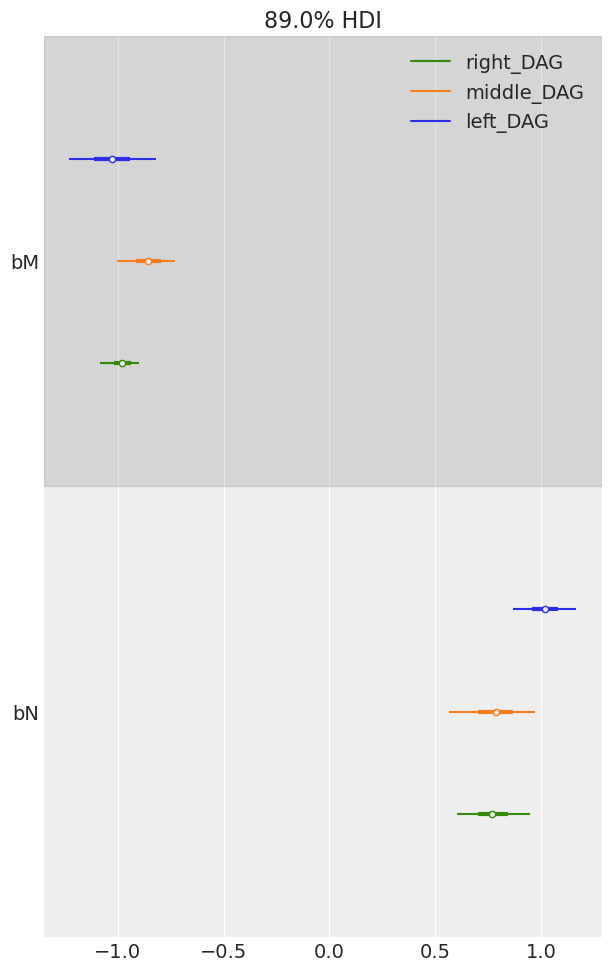

In [27]:
coeftab = {
    "left_DAG": m_left_DAG.sample_posterior(
        random.PRNGKey(1),
        p_left_DAG,
        (
            1,
            1000,
        ),
    ),
    "middle_DAG": m_middle_DAG.sample_posterior(
        random.PRNGKey(2),
        p_middle_DAG,
        (
            1,
            1000,
        ),
    ),
    "right_DAG": m_right_DAG.sample_posterior(
        random.PRNGKey(3),
        p_right_DAG,
        (
            1,
            1000,
        ),
    ),
}
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["bM", "bN"],
    hdi_prob=0.89,
)
plt.show()

It may be that the positive association between a larger body size (M) and larger neocortex percent (N) arises from tradeoffs between lifespan and learning. E.g. larger animals tend to live longer, _and_ in such animals the investment in learning may be better because learning can be amortized over a longer lifespan.

Then, both the larger body size and the large neocortex percentages influence milk compositions, but _each in a different direction_.

This would imply the first (left) DAG, but we cannot easily see which DAG is right. We will compute the **Markov equivalence set**.

In [28]:
# Code 5.44
dag5_7 = CausalGraphicalModel(
    nodes=["M", "K", "N"], edges=[("M", "K"), ("N", "K"), ("M", "N")]
)
coordinates = {"M": (0, 0.5), "K": (1, 1), "N": (2, 0.5)}
nodes = list(dag5_7.dag.nodes.keys())
edges = list(dag5_7.dag.edges.keys())
MElist = []
for i in range(2):
    for j in range(2):
        for k in range(2):
            try:
                new_dag = CausalGraphicalModel(
                    nodes=nodes,
                    edges=[
                        edges[0] if i == 0 else edges[0][::-1],
                        edges[1] if j == 0 else edges[1][::-1],
                        edges[2] if k == 0 else edges[2][::-1],
                    ],
                )
                MElist.append(new_dag)
            except:
                pass

In [60]:
m0 = MElist[0].draw()
m1 = MElist[1].draw()
m2 = MElist[2].draw()
m3 = MElist[3].draw()
m4 = MElist[4].draw()
m5 = MElist[5].draw()

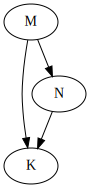

In [61]:
m0

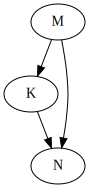

In [62]:
m1

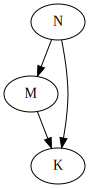

In [63]:
m2

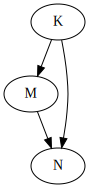

In [64]:
m3

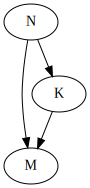

In [65]:
m4

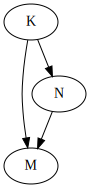

In [66]:
m5

## 5.3 Categorical variables